In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle, glob,shutil
from nilearn import plotting, maskers, datasets
import numpy as np
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nilearn.plotting import view_img_on_surf, view_img
from nltools.stats import isc, threshold, fdr
from tqdm import tqdm

import pandas as pd
from statsmodels.stats.multitest import multipletests
#from utils import *
import warnings
warnings.simplefilter("ignore")
import seaborn as sns

### Set up files and load

In [2]:
n_iter                 = 5000
alpha                  = 0.01

fmri_data_file         = "../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppEN-run-01.npy"
all293_rois_file       = '../../data_lpp/fmri_data/other/allcombined.nii'
masker_prefitting_file = '../../data_lpp/fmri_data/other/func_lpp.nii'

n_runs                 = 9
transient_cut          = 10

file = open('../../data_lpp/fmri_data/other/all293_masker_pickled.obj', 'rb') 
all293_masker_reopened = pickle.load(file)
file.close();

### V1: ISC within, bootstrap ISC, FDR, for each of 9 original runs and then averaged

In [86]:
isc_english_corrected = np.zeros((293,n_runs))
isc_french_corrected  = np.zeros((293,n_runs))
isc_chinese_corrected = np.zeros((293,n_runs))

for curr_run in range(n_runs):
    # French
    ts_data = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppFR-run-0" + str(curr_run+1) + ".npy")
    
    p_results = [];     isc_results = []
    for curr_roi in tqdm(range(293)):
            data_roi_df = pd.DataFrame(ts_data[transient_cut:-transient_cut,curr_roi,:])
            stats_boot = isc(data_roi_df, method='bootstrap', n_samples=n_iter, return_null=True)
            p_results.append(stats_boot['p']);  isc_results.append(stats_boot['isc'])

    thresh = fdr(np.asarray(p_results), q = alpha)
    isc_results = np.asarray(isc_results)
    isc_results[np.asarray(p_results) > thresh] = 0
    
    isc_french_corrected[:, curr_run]  = isc_results.T

    
    # Chinese
    ts_data = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppCN-run-0" + str(curr_run+1) + ".npy")
    
    p_results = [];     isc_results = []
    for curr_roi in tqdm(range(293)):
            data_roi_df = pd.DataFrame(ts_data[transient_cut:-transient_cut,curr_roi,:])
            stats_boot = isc(data_roi_df, method='bootstrap', n_samples=n_iter, return_null=True)
            p_results.append(stats_boot['p']);  isc_results.append(stats_boot['isc'])

    thresh = fdr(np.asarray(p_results), q = alpha)
    isc_results = np.asarray(isc_results)
    isc_results[np.asarray(p_results) > thresh] = 0
    
    isc_chinese_corrected[:, curr_run]  = isc_results.T

    
    # English
    ts_data = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppEN-run-0" + str(curr_run+1) + ".npy")
    
    p_results = [];     isc_results = []
    for curr_roi in tqdm(range(293)):
            data_roi_df = pd.DataFrame(ts_data[transient_cut:-transient_cut,curr_roi,:])
            stats_boot = isc(data_roi_df, method='bootstrap', n_samples=n_iter, return_null=True)
            p_results.append(stats_boot['p']);  isc_results.append(stats_boot['isc'])

    thresh = fdr(np.asarray(p_results), q = alpha)
    isc_results = np.asarray(isc_results)
    isc_results[np.asarray(p_results) > thresh] = 0
    
    isc_english_corrected[:, curr_run]  = isc_results.T


100%|█████████████████████████████████████████| 293/293 [00:39<00:00,  7.48it/s]


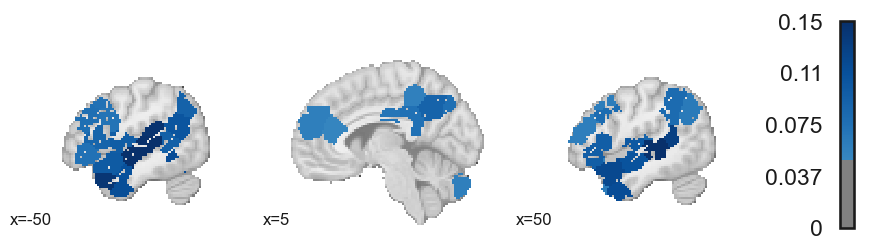

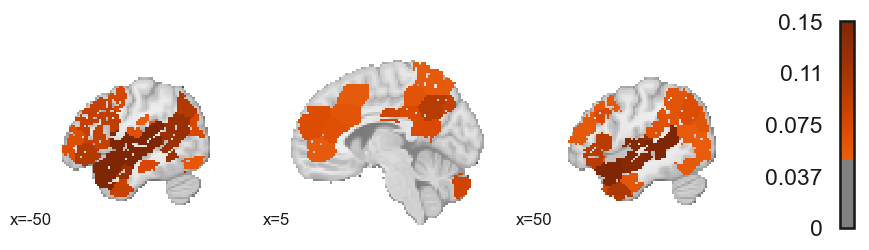

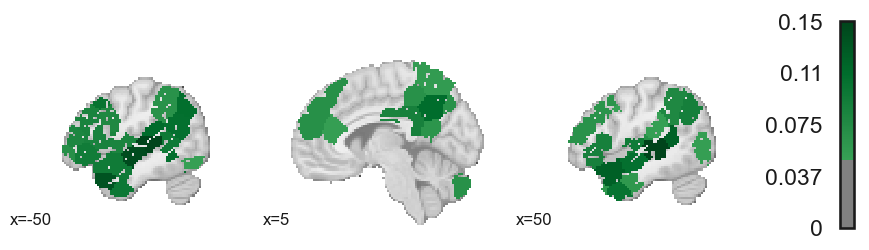

In [87]:
m_isc_corrected_fr = np.mean(isc_french_corrected, axis = 1)
m_isc_corrected_cn = np.mean(isc_chinese_corrected, axis = 1)
m_isc_corrected_en = np.mean(isc_english_corrected, axis = 1)


val_v_max = 0.15; slices_to_plot = [-50, 5, 50]

display = plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_corrected_fr, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Blues',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,);
ax = list(display.axes.values())[0].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[1].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[2].ax; ax.set_xlim(*ax.get_xlim()[::-1])
plt.show()

display = plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_corrected_cn, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Oranges',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,);
ax = list(display.axes.values())[0].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[1].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[2].ax; ax.set_xlim(*ax.get_xlim()[::-1])
plt.show()

display = plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_corrected_en, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Greens',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,);
ax = list(display.axes.values())[0].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[1].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[2].ax; ax.set_xlim(*ax.get_xlim()[::-1])
plt.show()

### V2: ISC within, bootstrap ISC, FDR, for each of 9 resampled runs and then averaged

In [6]:
isc_english_corrected = np.zeros((293,n_runs))
isc_french_corrected  = np.zeros((293,n_runs))
isc_chinese_corrected = np.zeros((293,n_runs))

run_lenghts = [291, 315, 338, 308, 283, 371, 340, 293, 368]


for curr_run in range(n_runs):
    # French
    ts_data = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppFR-run-0" + str(curr_run+1) +'_resampled' + str(run_lenghts[curr_run]) + ".npy")
    
    p_results = [];     isc_results = []
    for curr_roi in tqdm(range(293)):
            data_roi_df = pd.DataFrame(ts_data[transient_cut:-transient_cut,curr_roi,:])
            stats_boot = isc(data_roi_df, method='bootstrap', n_samples=n_iter, return_null=True)
            p_results.append(stats_boot['p']);  isc_results.append(stats_boot['isc'])

    thresh = fdr(np.asarray(p_results), q = alpha)
    isc_results = np.asarray(isc_results)
    isc_results[np.asarray(p_results) > thresh] = 0
    
    isc_french_corrected[:, curr_run]  = isc_results.T


    # Chinese
    ts_data = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppCN-run-0" + str(curr_run+1) + ".npy")
    
    p_results = [];     isc_results = []
    for curr_roi in tqdm(range(293)):
            data_roi_df = pd.DataFrame(ts_data[transient_cut:-transient_cut,curr_roi,:])
            stats_boot = isc(data_roi_df, method='bootstrap', n_samples=n_iter, return_null=True)
            p_results.append(stats_boot['p']);  isc_results.append(stats_boot['isc'])

    thresh = fdr(np.asarray(p_results), q = alpha)
    isc_results = np.asarray(isc_results)
    isc_results[np.asarray(p_results) > thresh] = 0
    
    isc_chinese_corrected[:, curr_run]  = isc_results.T

    
    # English
    ts_data = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppEN-run-0" + str(curr_run+1) + ".npy")
    
    p_results = [];     isc_results = []
    for curr_roi in tqdm(range(293)):
            data_roi_df = pd.DataFrame(ts_data[transient_cut:-transient_cut,curr_roi,:])
            stats_boot = isc(data_roi_df, method='bootstrap', n_samples=n_iter, return_null=True)
            p_results.append(stats_boot['p']);  isc_results.append(stats_boot['isc'])

    thresh = fdr(np.asarray(p_results), q = alpha)
    isc_results = np.asarray(isc_results)
    isc_results[np.asarray(p_results) > thresh] = 0
    
    isc_english_corrected[:, curr_run]  = isc_results.T

100%|█████████████████████████████████████████| 293/293 [00:38<00:00,  7.55it/s]


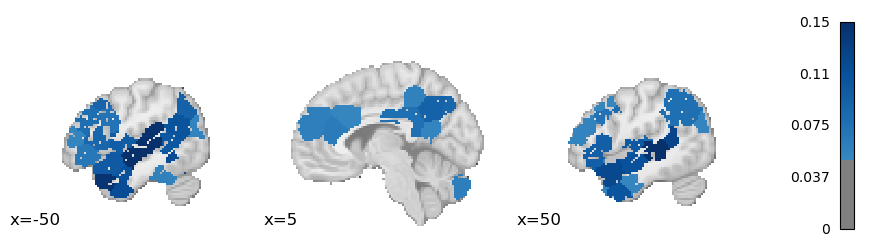

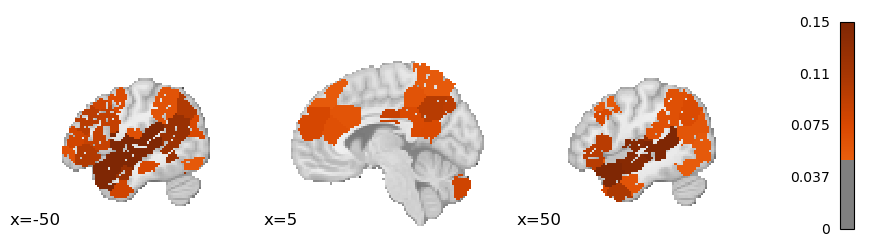

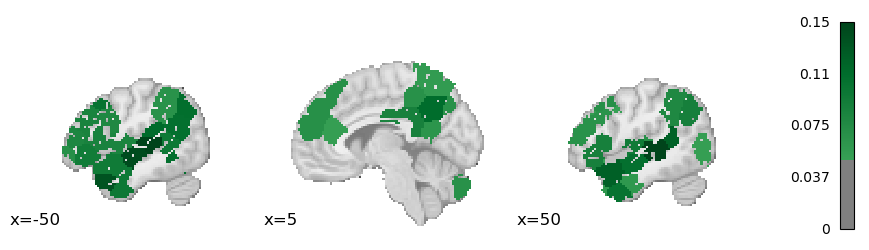

In [7]:
m_isc_corrected_fr = np.mean(isc_french_corrected, axis = 1)
m_isc_corrected_cn = np.mean(isc_chinese_corrected, axis = 1)
m_isc_corrected_en = np.mean(isc_english_corrected, axis = 1)


val_v_max = 0.15; slices_to_plot = [-50, 5, 50]

display = plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_corrected_fr, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Blues',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,);
ax = list(display.axes.values())[0].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[1].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[2].ax; ax.set_xlim(*ax.get_xlim()[::-1])
plt.show()

#'''
display = plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_corrected_cn, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Oranges',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,);
ax = list(display.axes.values())[0].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[1].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[2].ax; ax.set_xlim(*ax.get_xlim()[::-1])
plt.show()

display = plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_corrected_en, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Greens',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,);
ax = list(display.axes.values())[0].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[1].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[2].ax; ax.set_xlim(*ax.get_xlim()[::-1])
plt.show() #'''

### V3: ISC within, bootstrap ISC, FDR, for the resampled & concatenated runs

In [95]:
fr_data_file = '../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/fr_fmriall_resampled.npy'
cn_data_file = '../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/cn_fmriall_resampled.npy'
en_data_file = '../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/en_fmriall_resampled.npy'


# French
ts_data = np.load(cn_data_file)
    
p_results = [];     isc_results = []
for curr_roi in tqdm(range(293)):
            data_roi_df = pd.DataFrame(ts_data[transient_cut:-transient_cut,curr_roi,:])
            stats_boot = isc(data_roi_df, method='bootstrap', n_samples=n_iter, return_null=True)
            p_results.append(stats_boot['p']);  isc_results.append(stats_boot['isc'])

thresh = fdr(np.asarray(p_results), q = alpha)
isc_results = np.asarray(isc_results)
isc_results[np.asarray(p_results) > thresh] = 0
    
isc_french_corrected  = isc_results

# Chinese
ts_data = np.load(cn_data_file)
    
p_results = [];     isc_results = []
for curr_roi in tqdm(range(293)):
            data_roi_df = pd.DataFrame(ts_data[transient_cut:-transient_cut,curr_roi,:])
            stats_boot = isc(data_roi_df, method='bootstrap', n_samples=n_iter, return_null=True)
            p_results.append(stats_boot['p']);  isc_results.append(stats_boot['isc'])

thresh = fdr(np.asarray(p_results), q = alpha)
isc_results = np.asarray(isc_results)
isc_results[np.asarray(p_results) > thresh] = 0
    
isc_chinese_corrected  = isc_results

# English
ts_data = np.load(en_data_file)
    
p_results = [];     isc_results = []
for curr_roi in tqdm(range(293)):
            data_roi_df = pd.DataFrame(ts_data[transient_cut:-transient_cut,curr_roi,:])
            stats_boot = isc(data_roi_df, method='bootstrap', n_samples=n_iter, return_null=True)
            p_results.append(stats_boot['p']);  isc_results.append(stats_boot['isc'])

thresh = fdr(np.asarray(p_results), q = alpha)
isc_results = np.asarray(isc_results)
isc_results[np.asarray(p_results) > thresh] = 0
    
isc_english_corrected  = isc_results


100%|█████████████████████████████████████████| 293/293 [00:45<00:00,  6.47it/s]


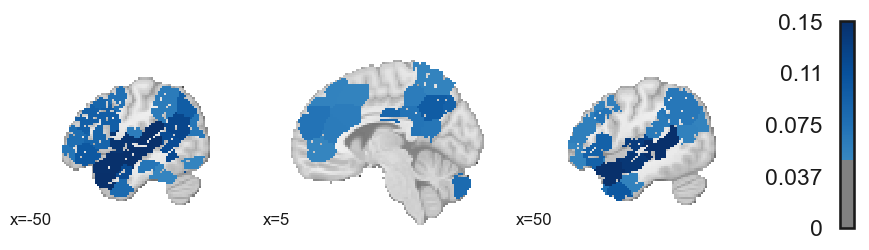

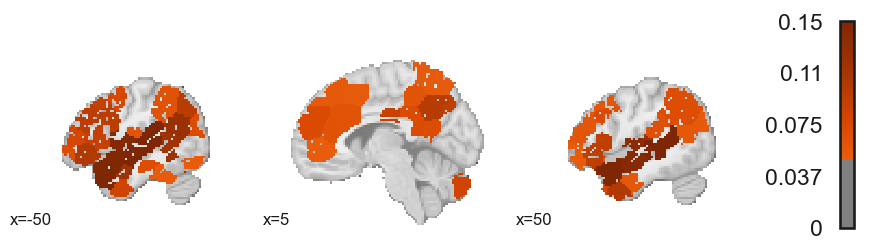

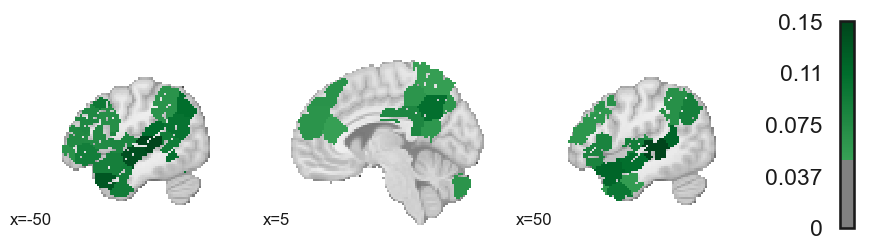

In [97]:
file = open('../../data_lpp/fmri_data/other/all293_masker_pickled.obj', 'rb') 
all293_masker_reopened = pickle.load(file)
file.close();

m_isc_corrected_fr = isc_french_corrected
m_isc_corrected_cn = isc_chinese_corrected
m_isc_corrected_en = isc_english_corrected


val_v_max = 0.15; slices_to_plot = [-50, 5, 50]

display = plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_corrected_fr, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Blues',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,);
ax = list(display.axes.values())[0].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[1].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[2].ax; ax.set_xlim(*ax.get_xlim()[::-1])
plt.show()

display = plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_corrected_cn, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Oranges',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,);
ax = list(display.axes.values())[0].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[1].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[2].ax; ax.set_xlim(*ax.get_xlim()[::-1])
plt.show()

display = plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(m_isc_corrected_en, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Greens',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,);
ax = list(display.axes.values())[0].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[1].ax; ax.set_xlim(*ax.get_xlim()[::-1]); ax = list(display.axes.values())[2].ax; ax.set_xlim(*ax.get_xlim()[::-1])
plt.show()

### Exploring additional variations of ISC statistics to demonstrate robustness

In [108]:
ts_data = np.concatenate( (np.load(fr_data_file),
                 np.load(en_data_file),
                 np.load(cn_data_file)), axis=2)
print(ts_data.shape)

p_results = [];     isc_results = []
for curr_roi in tqdm(range(293)):
            data_roi_df = pd.DataFrame(ts_data[transient_cut:-transient_cut,curr_roi,:])
            stats_boot = isc(data_roi_df, method='bootstrap', n_samples=n_iter, return_null=True)
            p_results.append(stats_boot['p']);  isc_results.append(stats_boot['isc'])

thresh = fdr(np.asarray(p_results), q = alpha)
isc_results = np.asarray(isc_results)
isc_results[np.asarray(p_results) > thresh] = 0

(2772, 293, 110)


100%|█████████████████████████████████████████| 293/293 [01:23<00:00,  3.50it/s]


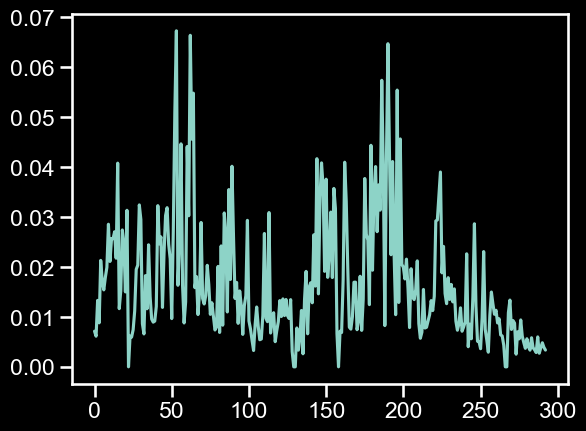

In [110]:
plt.plot(isc_results)

(5995, 293)


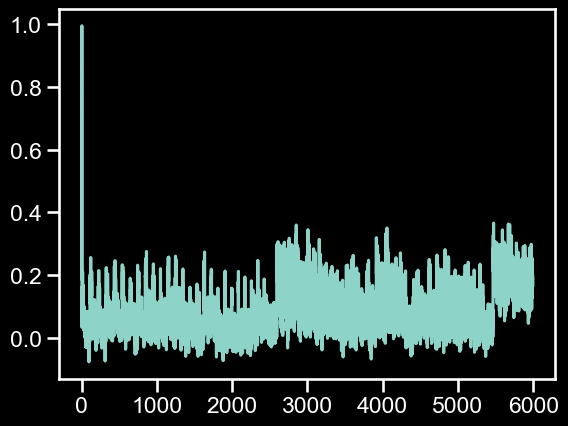

In [134]:
import sys
sys.path.append('../')
from lpp_utils import *

observed, p = phaseshift_isc_pairwise(ts_data, 
                                           pairwise=True,
                                           n_shifts=1)
print(observed.shape)

plt.plot(observed[:,62])

In [143]:

'''# load timeseries, swap axes
ts_data = np.load(fmri_data_file)
print("Shape of time series structure: " + str(ts_data.shape))

# set up mask
mask = Brain_Data(all293_rois_file)
mask_x = expand_mask(mask)
    
# run isc permutation/bootstrap analysis
p_results = []
isc_results = []
for curr_roi in tqdm(range(293)):
        #print(curr_roi)
        data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:])
        stats_boot = isc(data_roi_df, method='bootstrap', n_samples=n_iter, return_null=True)
        #print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")
        p_results.append(stats_boot['p'])
        isc_results.append(stats_boot['isc'])


# map isc results back to brain
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_results), mask_x), roi_to_brain(pd.Series(p_results), mask_x)
result_image = threshold(isc_r_brain, isc_p_brain, thr=fdr(np.asarray(p_results), q = alpha) ).to_nifti()

# visualize results
fig = plt.figure(figsize=(10, 2))
nilearn.plotting.plot_stat_map(    result_image, 
                                   bg_img       = '../../data_lpp/fmri_data/other/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.03,  #additional threshold for visualization
                                   vmax         = 0.25, 
                                   #cmap         = 'Oranges', 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20, 30, 50],
                                   annotate     = True,
                                   figure = fig); #'''
print('done')

done


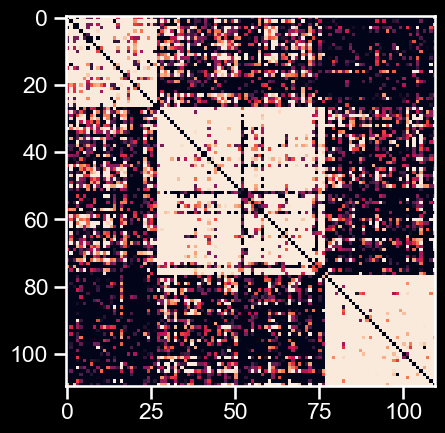

In [139]:
from scipy.spatial.distance import squareform
res = squareform(observed[:,62])
plt.imshow(res, vmin = 0.05, vmax = 0.1)

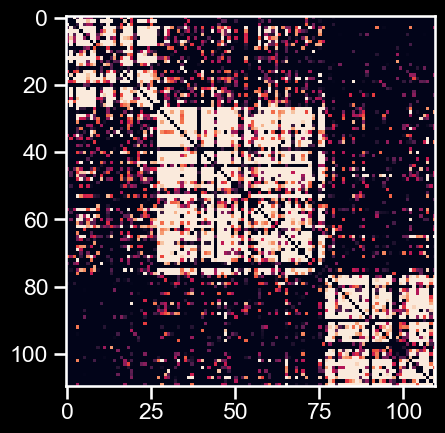

In [138]:
from scipy.spatial.distance import squareform
res = squareform(observed[:,89])
plt.imshow(res, vmin = 0.05, vmax = 0.1)

### asdf

100%|█████████████████████████████████████████| 293/293 [00:41<00:00,  7.12it/s]


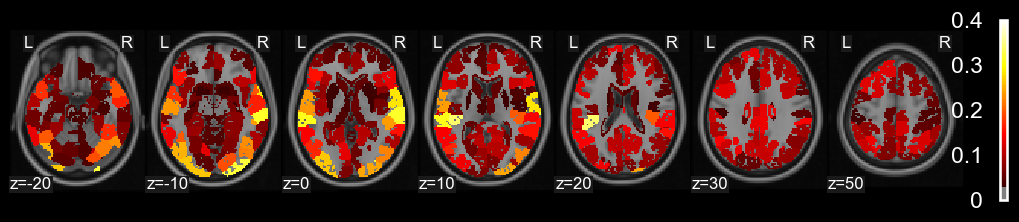

100%|█████████████████████████████████████████| 293/293 [00:41<00:00,  7.07it/s]


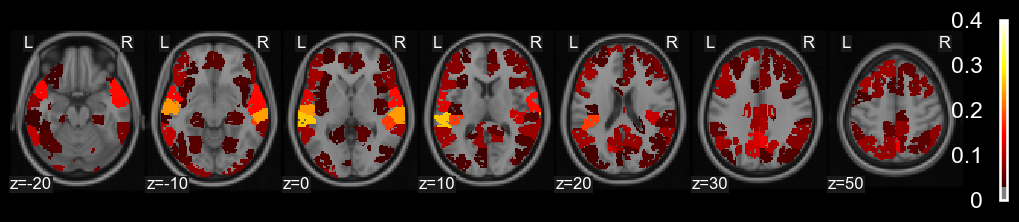

100%|█████████████████████████████████████████| 293/293 [00:41<00:00,  7.04it/s]


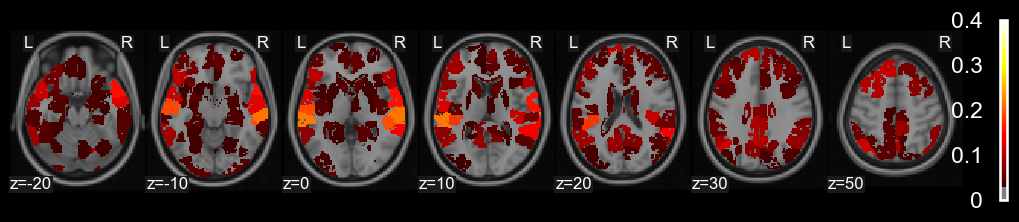

100%|█████████████████████████████████████████| 293/293 [00:42<00:00,  6.93it/s]


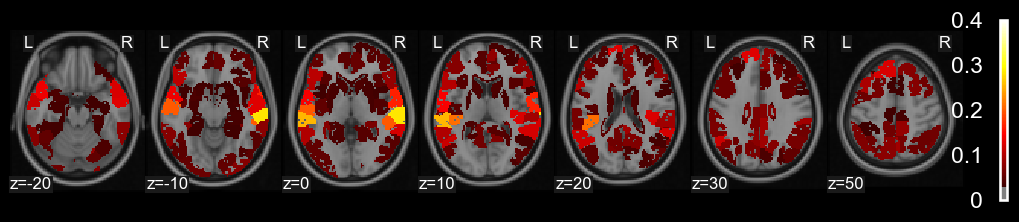

100%|█████████████████████████████████████████| 293/293 [00:41<00:00,  7.04it/s]


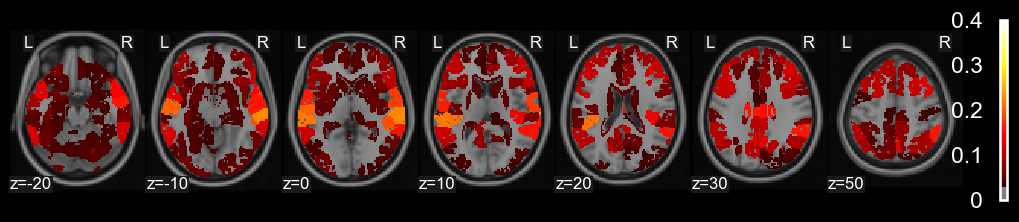

100%|█████████████████████████████████████████| 293/293 [00:42<00:00,  6.97it/s]


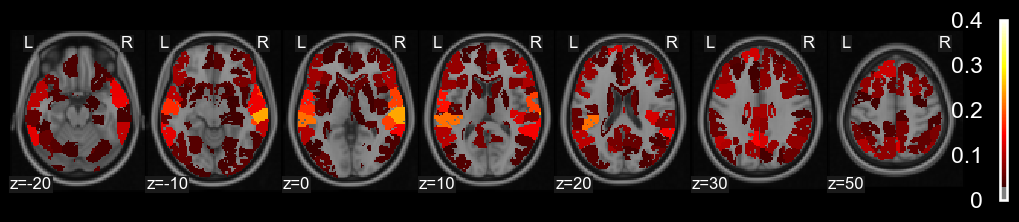

100%|█████████████████████████████████████████| 293/293 [00:40<00:00,  7.16it/s]


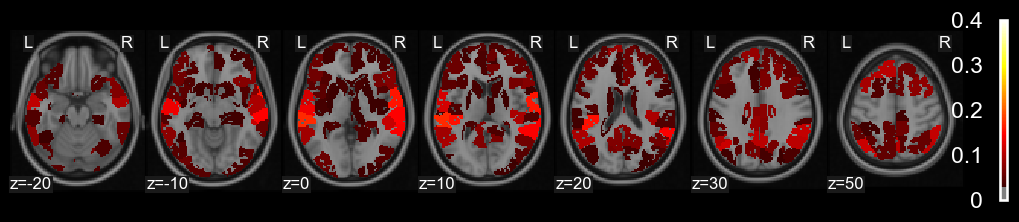

100%|█████████████████████████████████████████| 293/293 [00:41<00:00,  7.07it/s]


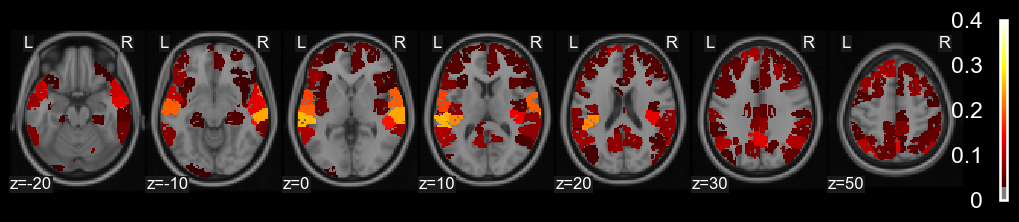

100%|█████████████████████████████████████████| 293/293 [00:40<00:00,  7.20it/s]


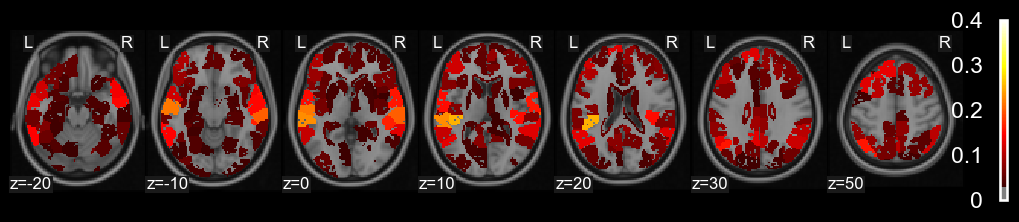

'\n    # French\n    curr_data = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppFR-run-0" + str(curr_run+1) + ".npy")\n    observed, p, distribution = phaseshift_isc(curr_data[transient_cut:-transient_cut,:,:], pairwise=True,summary_statistic=\'median\',n_shifts=n_perm)\n    isc_french[:, curr_run] = observed\n    q = multipletests(p, method=\'fdr_by\')[1]\n    corrected = q  < stats_threshold\n    corrected_res = np.zeros(observed.shape[0])\n    corrected_res[corrected] = observed[corrected]\n    isc_french_corrected[:, curr_run]  = corrected_res\n    \n    # Chinese\n    curr_data = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppCN-run-0" + str(curr_run+1) + ".npy")\n    observed, p, distribution = phaseshift_isc(curr_data[transient_cut:-transient_cut,:,:], pairwise=True,summary_statistic=\'median\',n_shifts=n_perm)\n    isc_chinese[:, curr_run] = observed\n    q = multipletests(p, method=\'fdr_by\')[1]\n    corrected = q 

In [34]:
n_runs = 9
transient_cut = 10
stats_threshold = 0.01
n_perm = 2 #1000

isc_english = np.zeros((293,n_runs))
isc_french  = np.zeros((293,n_runs))
isc_chinese =` np.zeros((293,n_runs))

isc_english_corrected = np.zeros((293,n_runs))
isc_french_corrected  = np.zeros((293,n_runs))
isc_chinese_corrected = np.zeros((293,n_runs))

for curr_run in range(n_runs):
    # English
    ts_data = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppEN-run-0" + str(curr_run+1) + ".npy")
    
    p_results = [], isc_results = []
    for curr_roi in tqdm(range(293)):
            data_roi_df = pd.DataFrame(ts_data[transient_cut:-transient_cut,curr_roi,:])
            stats_boot = isc(data_roi_df, method='bootstrap', n_samples=n_iter, return_null=True)
            p_results.append(stats_boot['p'])
            isc_results.append(stats_boot['isc'])

    # map isc results back to brain
    isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_results), mask_x), roi_to_brain(pd.Series(p_results), mask_x)
    result_image = threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data, q = alpha)).to_nifti()
    
    # visualize results
    fig = plt.figure(figsize=(10, 2))
    nilearn.plotting.plot_stat_map(    result_image, 
                                       bg_img       = '../../data_lpp/fmri_data/other/MNI152_T1_2mm.nii.gz',
                                       threshold    = 0.03,  #additional threshold for visualization
                                       vmax         = 0.4, 
                                       #cmap         = 'Oranges', 
                                       draw_cross   = False,
                                       display_mode = 'x',
                                       cut_coords   = [ -20, -10, 0, 10, 20, 30, 50],
                                       annotate     = True,
                                       figure = fig);
    plt.show()
    
'''
    # French
    curr_data = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppFR-run-0" + str(curr_run+1) + ".npy")
    observed, p, distribution = phaseshift_isc(curr_data[transient_cut:-transient_cut,:,:], pairwise=True,summary_statistic='median',n_shifts=n_perm)
    isc_french[:, curr_run] = observed
    q = multipletests(p, method='fdr_by')[1]
    corrected = q  < stats_threshold
    corrected_res = np.zeros(observed.shape[0])
    corrected_res[corrected] = observed[corrected]
    isc_french_corrected[:, curr_run]  = corrected_res
    
    # Chinese
    curr_data = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri/task-lppCN-run-0" + str(curr_run+1) + ".npy")
    observed, p, distribution = phaseshift_isc(curr_data[transient_cut:-transient_cut,:,:], pairwise=True,summary_statistic='median',n_shifts=n_perm)
    isc_chinese[:, curr_run] = observed
    q = multipletests(p, method='fdr_by')[1]
    corrected = q  < stats_threshold
    corrected_res = np.zeros(observed.shape[0])
    corrected_res[corrected] = observed[corrected]
    isc_chinese_corrected[:, curr_run]  = corrected_res #'''

In [48]:
isc_r_brain

nltools.data.brain_data.Brain_Data(data=(238955,), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)

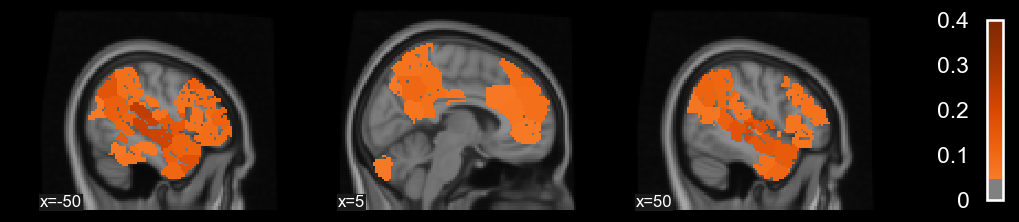

In [42]:
    # visualize results
    fig = plt.figure(figsize=(10, 2))
    nilearn.plotting.plot_stat_map(    result_image, 
                                       bg_img       = '../../data_lpp/fmri_data/other/MNI152_T1_2mm.nii.gz',
                                       threshold    = 0.05,  #additional threshold for visualization
                                       vmax         = 0.4, 
                                       cmap         = 'Oranges', 
                                       draw_cross   = False,
                                       display_mode = 'x',
                                       cut_coords   = [ -50,  5,  50],
                                       annotate     = True,
                                       figure = fig);
    plt.show()

## Exploring additional variants of ISC stats

In [26]:
curr_roi    = 62
data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:] )

stats_circle = isc(data_roi_df, method='circle_shift', n_samples=5000, return_null=True)
print(f"ISC: {stats_circle['isc']:.02}, p = {stats_circle['p']:.03}")

stats_phase = isc(data_roi_df, method='phase_randomize', n_samples=5000, return_null=True)
print(f"ISC: {stats_phase['isc']:.02}, p = {stats_phase['p']:.03}")

stats_boot = isc(data_roi_df, method='bootstrap', n_samples=5000, return_null=True)
print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

ISC: 0.31, p = 0.0002
ISC: 0.31, p = 0.0002
ISC: 0.31, p = 0.0002


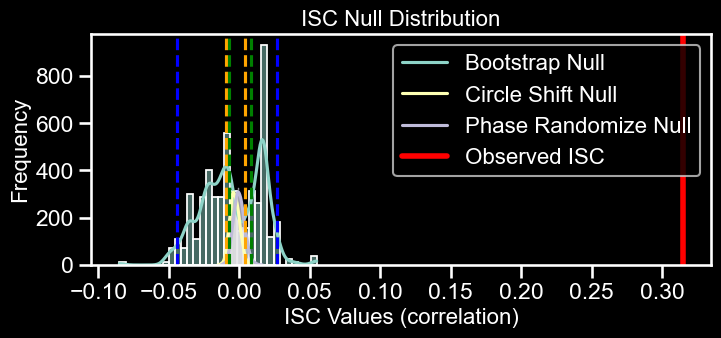

In [27]:
fs = 16

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

plt.figure(figsize=(8,3));
sns.histplot(stats_boot['null_distribution'] - stats_boot['isc'], kde=True, label='Bootstrap');
sns.histplot(stats_circle['null_distribution'], kde=True, label='Bootstrap');
sns.histplot(stats_phase['null_distribution'], kde=True, label='Bootstrap');
plt.ylabel('Frequency', fontsize= fs);
plt.xlabel('ISC Values (correlation)', fontsize= fs);
plt.title('ISC Null Distribution', fontsize= fs);
plt.axvline(stats_boot['isc'], linestyle='-', color='red', linewidth=4);
plt.legend(['Bootstrap Null','Circle Shift Null', 'Phase Randomize Null', 'Observed ISC'], fontsize=fs);
    
plt.axvline(stats_boot['ci'][0] - stats_boot['isc'], linestyle='--', color='blue');
plt.axvline(stats_boot['ci'][1] - stats_boot['isc'], linestyle='--', color='blue');
    
plt.axvline(stats_circle['ci'][0], linestyle='--', color='orange');
plt.axvline(stats_circle['ci'][1], linestyle='--', color='orange');
    
plt.axvline(stats_phase['ci'][0], linestyle='--', color='green');
plt.axvline(stats_phase['ci'][1], linestyle='--', color='green');
plt.show()

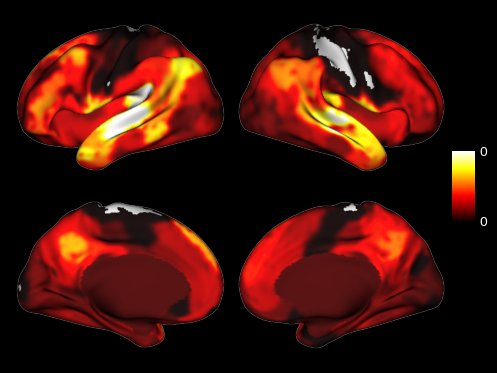

In [47]:
from surfplot import Plot
from neuromaps.datasets import fetch_fslr
from neuromaps.transforms import mni152_to_fslr
import panel as pn
pn.extension('vtk')

#import os
#os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
#os.environ['DISPLAY'] = ':99'

# Fetch fsLR surfaces from neuromaps
surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
sulc_lh, sulc_rh = surfaces['sulc']

# Convert volumetric MNI data to fsLR surface
gii_lh, gii_rh = mni152_to_fslr(nilearn.image.smooth_img(result_image, 4), method='linear')

# Plot example ROI on surface
p = Plot(surf_lh=lh, surf_rh=rh, brightness=.7)
p.add_layer({'left': gii_lh, 'right': gii_rh}, cmap='hot', color_range=(-0., 0.2))
cbar_kws = dict(location='right', draw_border=False, aspect=3,
                shrink=.2, decimals=0, pad=0, n_ticks=2)
fig = p.build(cbar_kws=cbar_kws)
